In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from collections import Counter
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import SnowballStemmer

In [2]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [3]:
%matplotlib inline

In [4]:
datos_originales = pd.read_excel("RESPUESTAS ENCUESTA.xlsx",sheet_name="DATOS ORIGINALES")
print(datos_originales.columns)

Index(['No.', 'Edad', 'Sexo', 'Nivel Educativo',
       '¿Qué beneficios cree usted que puede tener esta inteligencia artificial en el campo de la medicina?',
       'Le han realizado una tomografía de cráneo a usted o a un familiar o conocido cercano, ¿para qué le sirvió a su médico este estudio?',
       '¿Qué beneficio cree que pueda tener la inteligencia artificial en el estudio que su médico le solicitó a su familiar?',
       'En su opinión, ¿qué beneficios o riesgo puede tener la inteligencia artificial?',
       '¿Qué otros estudios médicos conoce, en los cuales considera que se pueda aplicar la inteligencia artificial?'],
      dtype='object')


In [5]:
datos_primera_pregunta = pd.read_excel("RESPUESTAS ENCUESTA.xlsx",sheet_name="PRIMERA PREGUNTA")
datos_segunda_pregunta = pd.read_excel("RESPUESTAS ENCUESTA.xlsx",sheet_name="SEGUNDA PREGUNTA")
datos_tercera_pregunta = pd.read_excel("RESPUESTAS ENCUESTA.xlsx",sheet_name="TERCERA PREGUNTA")
datos_cuarta_pregunta = pd.read_excel("RESPUESTAS ENCUESTA.xlsx",sheet_name="CUARTA PREGUNTA")
datos_quinta_pregunta = pd.read_excel("RESPUESTAS ENCUESTA.xlsx",sheet_name="QUINTA PREGUNTA")

In [59]:
datos_tipo_conocimiento = pd.Series(name="TIPO CONOCIMIENTO")
datos_tipo_conocimiento = pd.DataFrame(datos_tipo_conocimiento)

for pregunta in [datos_primera_pregunta,datos_segunda_pregunta,datos_tercera_pregunta,datos_cuarta_pregunta,datos_quinta_pregunta]:
    datos_tipo_conocimiento =  datos_tipo_conocimiento.append(pd.DataFrame(pregunta["TIPO CONOCIMIENTO"]))

### Convertir el nivel educativo a una representación numérica

In [6]:
datos_originales["Nivel Educativo"].unique()

array(['Universitario', 'Maestria', 'Tecnica', 'Diversificado'],
      dtype=object)

In [7]:
nivel_educativo_to_num = {"Diversificado":1,"Tecnica":2,"Universitario":3,"Maestria":4}
num_to_nivel_educativo = {nivel_educativo_to_num[nivel_educativo]:nivel_educativo for nivel_educativo in nivel_educativo_to_num}

In [8]:
datos_originales = datos_originales.replace({"Nivel Educativo":nivel_educativo_to_num})

In [9]:
stopwords = set(["con","como","no","de","y","en","el","a","que","para","la",
                 "mas","un","una","los","puede","o","las","es","al","se","más",
                 "si","del","por"])

In [10]:
def remover_tildes(s):
    reemplazar = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in reemplazar:
        s = s.replace(a, b)
    return s

In [11]:
def remover_plural(s,n):
    text =''
    for word in s.split():
        text +=  (word, word[ 0: len(word) - 1])[(word[-1] =='s') & (len(word)>n )]+' '
    return text

remover_plural ('textos prueba textos',4)

'texto prueba texto '

In [12]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('spanish.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def correction_phrase(text):
    text_corrected =''
    for word in text.split():
        text_corrected += correction(word)+' '
    return text_corrected


In [13]:
def clean_and_pre_process(corpus):
    #stemmer = SnowballStemmer("spanish")
    corpus = corpus.lower()
    corpus = corpus.translate(str.maketrans('', '', string.punctuation))
    #corpus = correction_phrase(corpus) 

    corpus = remover_tildes(corpus)
    corpus = remover_plural(corpus,4)

    #corpus = " ".join([stemmer.stem(word) for word in corpus.split()])
    
    return corpus

clean_and_pre_process("hola mundo. este , es un. tipo; varoas médico IA MEDICO si")

'hola mundo este es un tipo varoa medico ia medico si '

In [14]:
preguntas_abiertas = datos_originales[datos_originales.columns[4:]]

corpus_global = ""

for column in preguntas_abiertas.columns:
    corpus_global = corpus_global + preguntas_abiertas[column].str.cat(sep=" ")
    
corpus_global = clean_and_pre_process(corpus_global)

word_to_int = dict()
int_to_word = dict()
for idx,word in enumerate(corpus_global.split()):
    word_to_int[word] = idx
    int_to_word[idx] = word

In [15]:
def calc_tf_idf(documents_series):
    documents_series =  documents_series.apply(clean_and_pre_process)
    vectorizer = CountVectorizer(min_df=.0025, max_df=.25)
    counts = vectorizer.fit_transform(documents_series)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(counts.toarray()).toarray()
    
    return counts.toarray(),transformer,vectorizer,tfidf

result,transformer,vectorizer,tfidf = calc_tf_idf(datos_originales[datos_originales.columns[4]])



In [16]:
def analisis_categorias(datos,pregunta):
    figure = plt.figure(figsize=(12,12))
    ax = figure.add_subplot(1,1,1)
    
    results_dict = dict(datos[pregunta].value_counts())
    labels = results_dict.keys()
    values = np.array([results_dict[key] for key in results_dict.keys()])
    max_position = np.argmax(values)
    explode = np.zeros_like(values,dtype=float)
    explode[0] = 0.1
    #print(explode,max_position)
    
    #datos[pregunta].value_counts().plot(kind="pie",autopct='%1.1f%%',title="")
    
    ax.pie(values,explode=explode,labels=None,autopct='%1.1f%%',shadow=True)
    legend = ax.legend()
    legend = None
    #legend.remove()
    ax.legend(labels=labels,loc='upper center', bbox_to_anchor=(0.5, -0.05),prop={'size': 20})
    #legend.loc("upper right")
    plt.show()
    
    return datos[pregunta].value_counts()
    
#pregunta="¿Qué beneficios cree usted que puede tener esta inteligencia artificial en el campo de la medicina?"
#dict(analisis_categorias(datos_primera_pregunta,pregunta))



In [17]:
df  = pd.DataFrame(result,columns=vectorizer.get_feature_names())

df.describe()

,acercarno,acertado,adema,adn,agilizar,ahorrar,ahorro,al,algun,alguna,...,utilizarse,va,varoa,velocidad,ver,vida,vision,vista,ya,yo
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,0.018519,0.018519,0.018519,0.018519,0.018519,0.018519,0.018519,0.092593,0.037037,0.018519,...,0.018519,0.018519,0.018519,0.037037,0.018519,0.055556,0.018519,0.018519,0.055556,0.018519
std,0.136083,0.136083,0.136083,0.136083,0.136083,0.136083,0.136083,0.292582,0.272166,0.136083,...,0.136083,0.136083,0.136083,0.190626,0.136083,0.231212,0.136083,0.136083,0.231212,0.136083
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
tfidf_df = pd.DataFrame(tfidf,columns=vectorizer.get_feature_names())

tfidf_df.describe()

,acercarno,acertado,adema,adn,agilizar,ahorrar,ahorro,al,algun,alguna,...,utilizarse,va,varoa,velocidad,ver,vida,vision,vista,ya,yo
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,0.004256,0.009163,0.003042,0.005687,0.010123,0.005469,0.005595,0.014686,0.006759,0.010078,...,0.003483,0.004258,0.003945,0.016732,0.003945,0.023333,0.004258,0.004256,0.015649,0.007196
std,0.031273,0.067337,0.022350,0.041794,0.074392,0.040186,0.041115,0.047775,0.049672,0.074059,...,0.025596,0.031289,0.028990,0.104303,0.028990,0.108697,0.031289,0.031273,0.067946,0.052880
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.229807,0.494825,0.164241,0.307123,0.546668,0.295308,0.302132,0.217677,0.365010,0.544217,...,0.188089,0.229927,0.213029,0.754700,0.213029,0.679595,0.229927,0.229807,0.392388,0.388587


In [19]:
def correlacion_edad_palabras(matriz_conteos,vector_edad,conteos_vectorizer,topk = 20):
    edad_y_conteos = np.hstack((np.expand_dims(vector_edad,1),matriz_conteos))
    
    coeficiente_correlacion  = np.corrcoef(edad_y_conteos.T)[0,1:]
    sorted_correlated = np.argsort(coeficiente_correlacion)
    
    positivos_count = 0
    lista_positivos = {}
    
    for index in range(len(sorted_correlated)-1,0,-1):
        pos = sorted_correlated[index]
        if not vectorizer.get_feature_names()[pos] in stopwords:
            #lista_positivos.append((vectorizer.get_feature_names()[pos],coeficiente_correlación[pos]))
            lista_positivos[vectorizer.get_feature_names()[pos]] = coeficiente_correlacion[pos]
            positivos_count += 1
            
            if positivos_count >= topk:
                break
                
                
    negativos_count = 0
    lista_negativos = {}
    
    for index in range(len(sorted_correlated)):
        pos = sorted_correlated[index]
        
        if not vectorizer.get_feature_names()[pos] in stopwords:
            lista_negativos[vectorizer.get_feature_names()[pos]] = coeficiente_correlacion[pos]
            #lista_negativos.append((vectorizer.get_feature_names()[pos],coeficiente_correlación[pos]))
            negativos_count += 1
            
            if negativos_count >= topk:
                break
                
    fig = plt.figure(figsize=(15,15))
    
    ax = fig.add_subplot(1,2,1)
    ax.barh(list(lista_positivos.keys()),list(lista_positivos.values()))
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.barh(list(lista_negativos),list(lista_negativos.values()))
    
    plt.show()
        
    return lista_positivos,lista_negativos

In [20]:
def analisis_frecuencia_palabras(corpus):
    figure = plt.figure(figsize =(15,15))
    
    corpus = clean_and_pre_process(corpus)
    corpus_list = corpus.split()
    vocabulario = set(corpus_list)
    conteo_corpus = Counter(corpus_list)
    conteo_corpus   = Counter({key: conteo_corpus[key] for key in conteo_corpus if key not in stopwords})
    bigramas = list(nltk.bigrams(corpus_list))
    conteo_bigramas = Counter(bigramas)
    conteo_bigramas = Counter({bigram:conteo_bigramas[bigram] for bigram in conteo_bigramas if bigram[0] not in stopwords and bigram[1] not in stopwords})
    trigramas = list(nltk.trigrams(corpus_list))
    conteo_trigramas = Counter(trigramas)
    conteo_trigramas = Counter({trigram:conteo_trigramas[trigram] for trigram in conteo_trigramas if trigram[0] not in stopwords and trigram[1] not in stopwords})
    
    
    palabra,conteo  = zip(*conteo_corpus.most_common())
    
    figure.add_subplot(2,3,1).barh(palabra[:10],conteo[:10])
    
    wordcloud_corpus = WordCloud(stopwords=stopwords).generate(corpus)
    figure.add_subplot(2,3,4).imshow(wordcloud_corpus,interpolation="bilinear",aspect="auto")
    #plt.show()
    
    bigramas_comunes,conteo = zip(*conteo_bigramas.most_common())
    bigrama = [" ".join(bigram) for bigram in bigramas_comunes]
    figure.add_subplot(2,3,2).barh(bigrama[:10],conteo[:10])
    #plt.show()
    
    wordcloud_bigrams = WordCloud().generate(" ".join(["_".join(bigram)  for bigram in bigramas_comunes[:15]]))
    figure.add_subplot(2,3,5).imshow(wordcloud_bigrams,interpolation="bilinear",aspect="auto")
    
    
    trigramas_comunes,conteo = zip(*conteo_trigramas.most_common())
    trigrama = [" ".join(trigram) for trigram in trigramas_comunes]
    figure.add_subplot(2,3,3).barh(trigrama[:10],conteo[:10])
    
    wordcloud_trigramas = WordCloud().generate(" ".join(["_".join(trigram) for trigram in trigramas_comunes[:15]]))
    figure.add_subplot(2,3,6).imshow(wordcloud_trigramas,interpolation ="bilinear",aspect="auto")
    
    plt.show()
    return corpus_list,vocabulario



### Análisis de frecuencia global

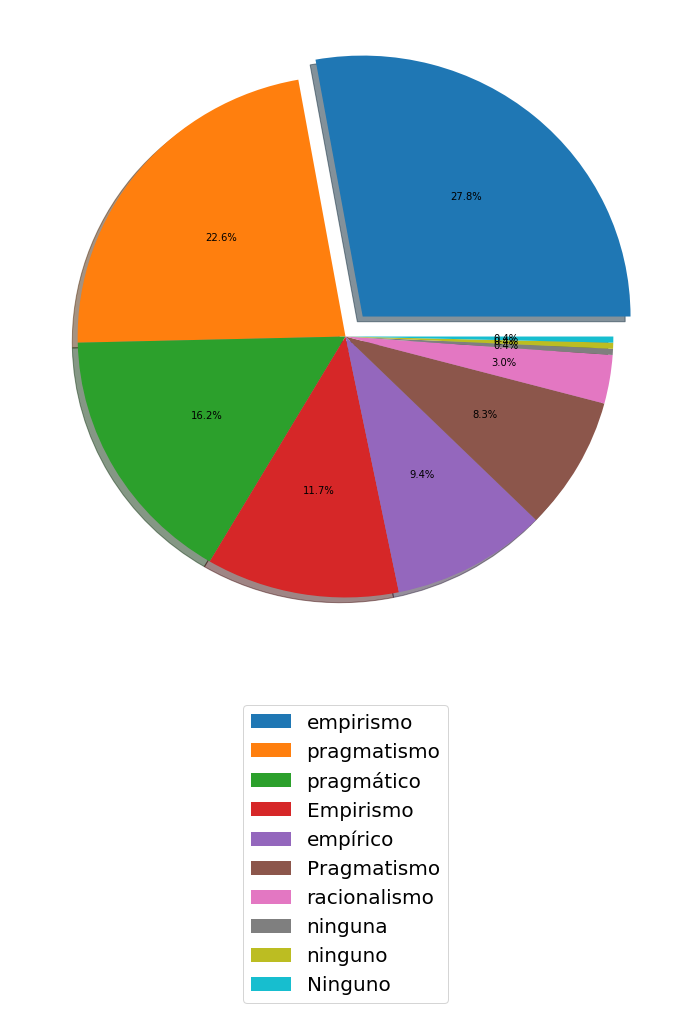

empirismo       74
pragmatismo     60
pragmático      43
Empirismo       31
empírico        25
Pragmatismo     22
racionalismo     8
ninguna          1
ninguno          1
Ninguno          1
Name: TIPO CONOCIMIENTO, dtype: int64

In [60]:
pregunta="TIPO CONOCIMIENTO"
analisis_categorias(datos_tipo_conocimiento,pregunta)

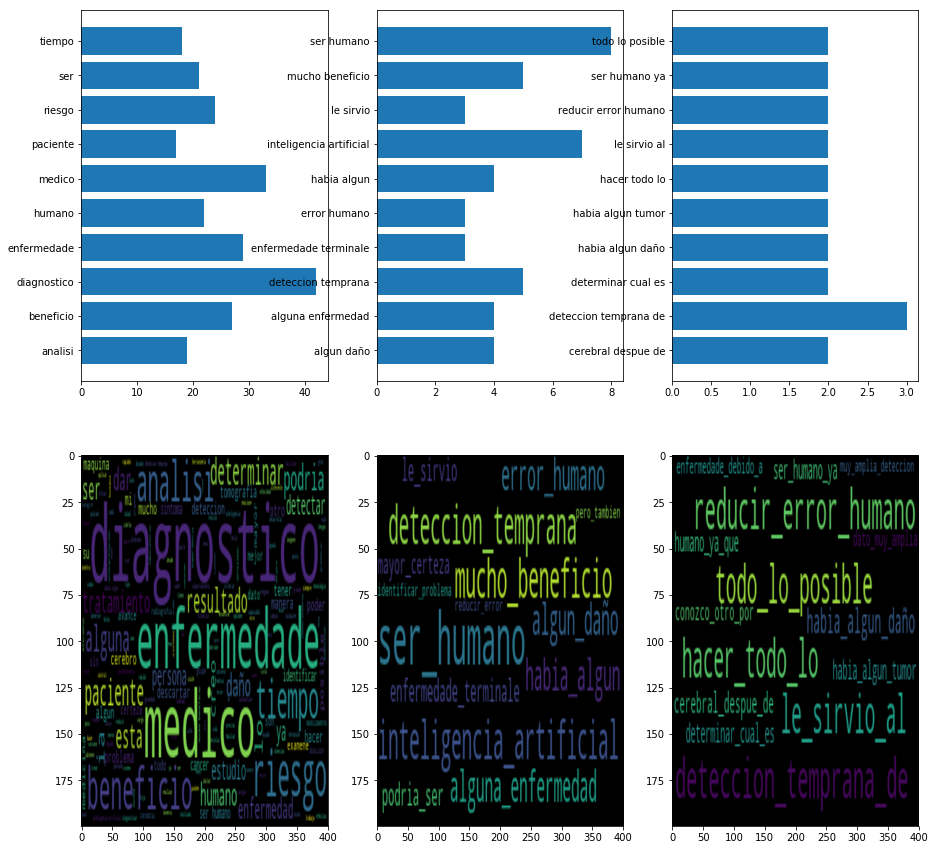

In [21]:
resultado =  analisis_frecuencia_palabras(corpus_global)


Podemos observar algunas cosas interesantes
* "diagnóstico" es predominante, lo cual indica que se cree que la IA puede ser usada para diagnóstico.
* "beneficio" es también predominante, la percepción hacía la IA es mayormente positiva, aun que podemos ver que también esta presente la palabra "riesgo" , se necesita analizar no por palabras si no por n-gramas para ver que palabras acompañan a riesgo, con el objetivo de determinar si en conjunto con otras palabras la muestra expresa que considera que existirá una disminución de riesgo o bien si consieran a la IA riesgosa.
* "enfermedades" es otra palabra predominante ,algo posiblemente de esperarse y posiblemente asociado con "diagnóstico"

## Pregunta 1:  ¿Qué beneficios cree usted que puede tener esta inteligencia artificial en el campo de la medicina?

### Análisis de frecuencia de palabras

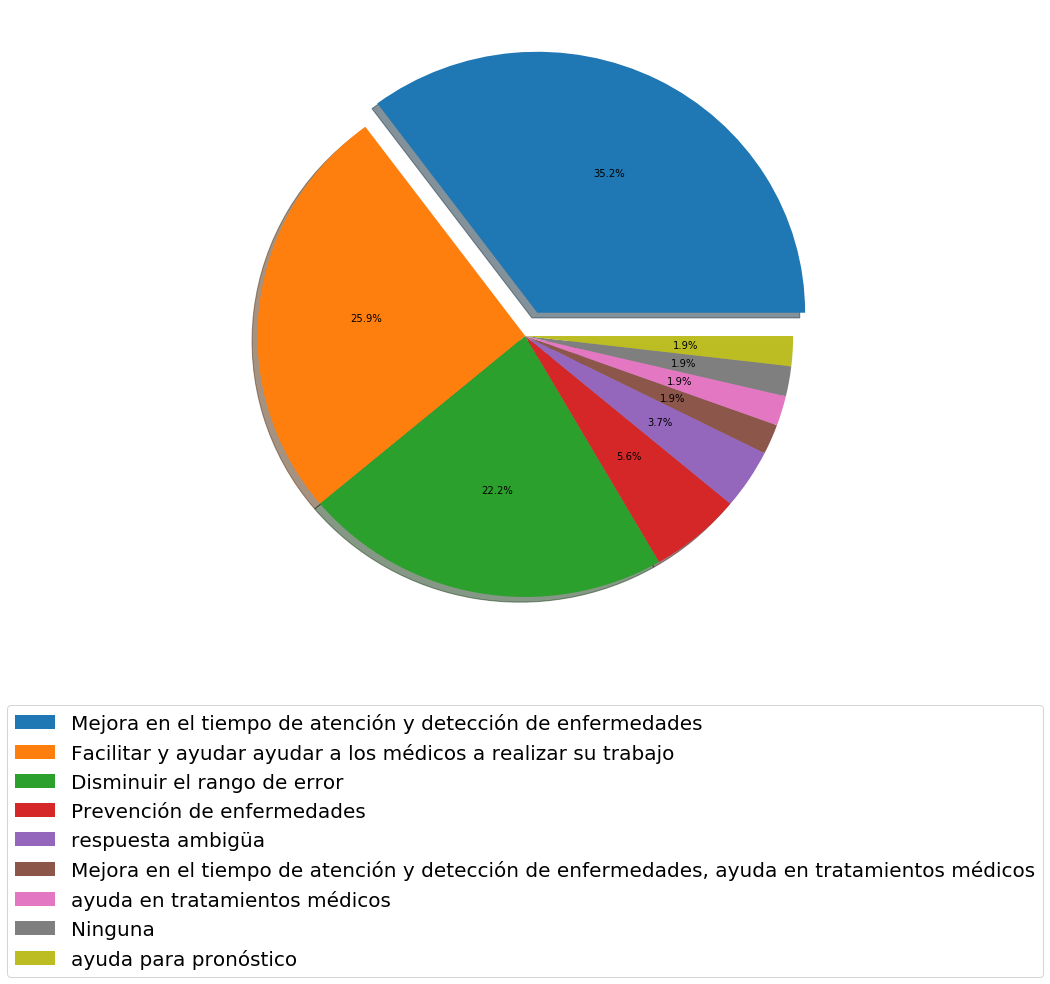

Mejora en el tiempo de atención y detección de enfermedades                                   19
Facilitar y ayudar ayudar a los médicos a realizar su trabajo                                 14
Disminuir el rango de error                                                                   12
Prevención de enfermedades                                                                     3
respuesta ambigüa                                                                              2
Mejora en el tiempo de atención y detección de enfermedades, ayuda en tratamientos médicos     1
ayuda en tratamientos médicos                                                                  1
Ninguna                                                                                        1
ayuda para pronóstico                                                                          1
Name: ¿Qué beneficios cree usted que puede tener esta inteligencia artificial en el campo de la medicina?, dtype: int64

In [22]:
pregunta="¿Qué beneficios cree usted que puede tener esta inteligencia artificial en el campo de la medicina?"
analisis_categorias(datos_primera_pregunta,pregunta)

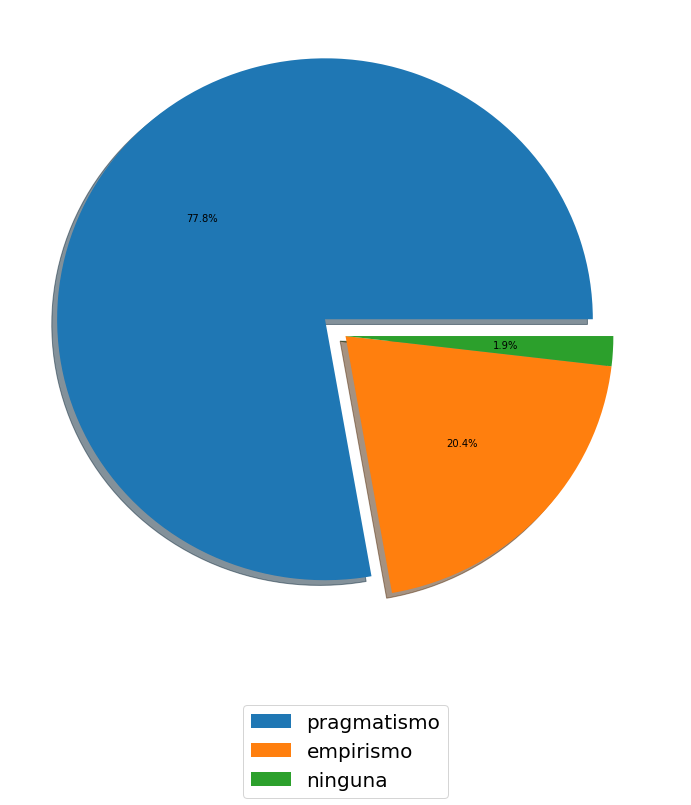

pragmatismo    42
empirismo      11
ninguna         1
Name: TIPO CONOCIMIENTO, dtype: int64

In [23]:
pregunta="TIPO CONOCIMIENTO"
analisis_categorias(datos_primera_pregunta,pregunta)

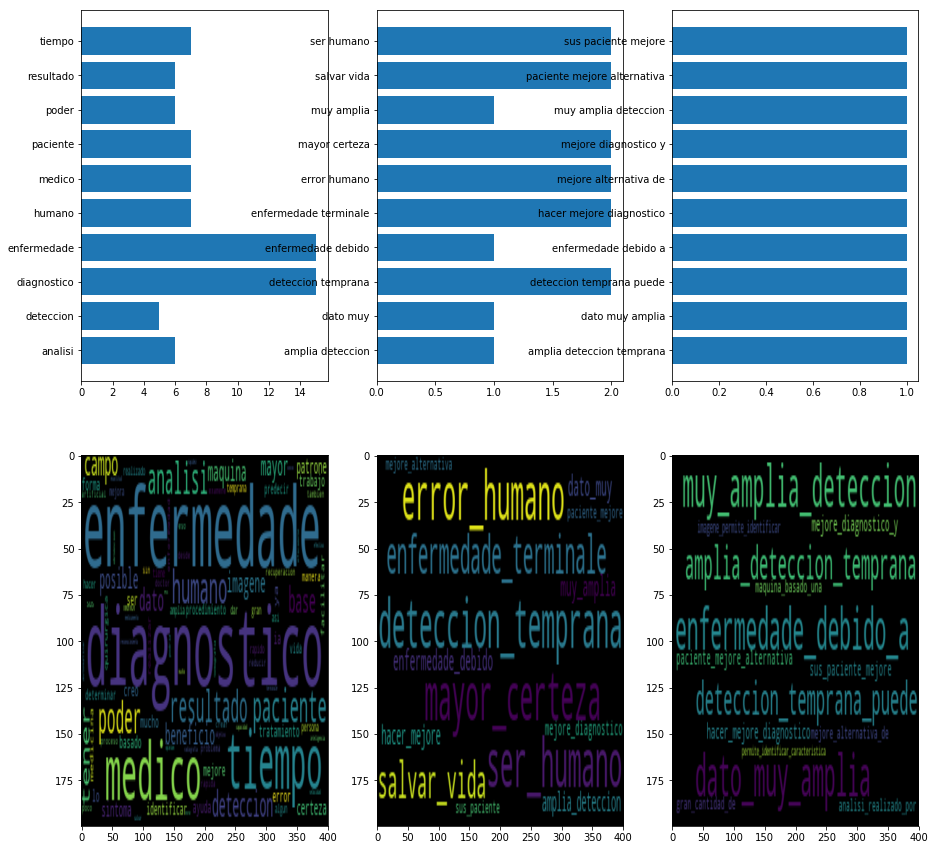

In [24]:
resultados_pregunta1 = datos_originales["¿Qué beneficios cree usted que puede tener esta inteligencia artificial en el campo de la medicina?"]
pregunta1_corpus = resultados_pregunta1.str.cat(sep=" ")
resultado = analisis_frecuencia_palabras(pregunta1_corpus)

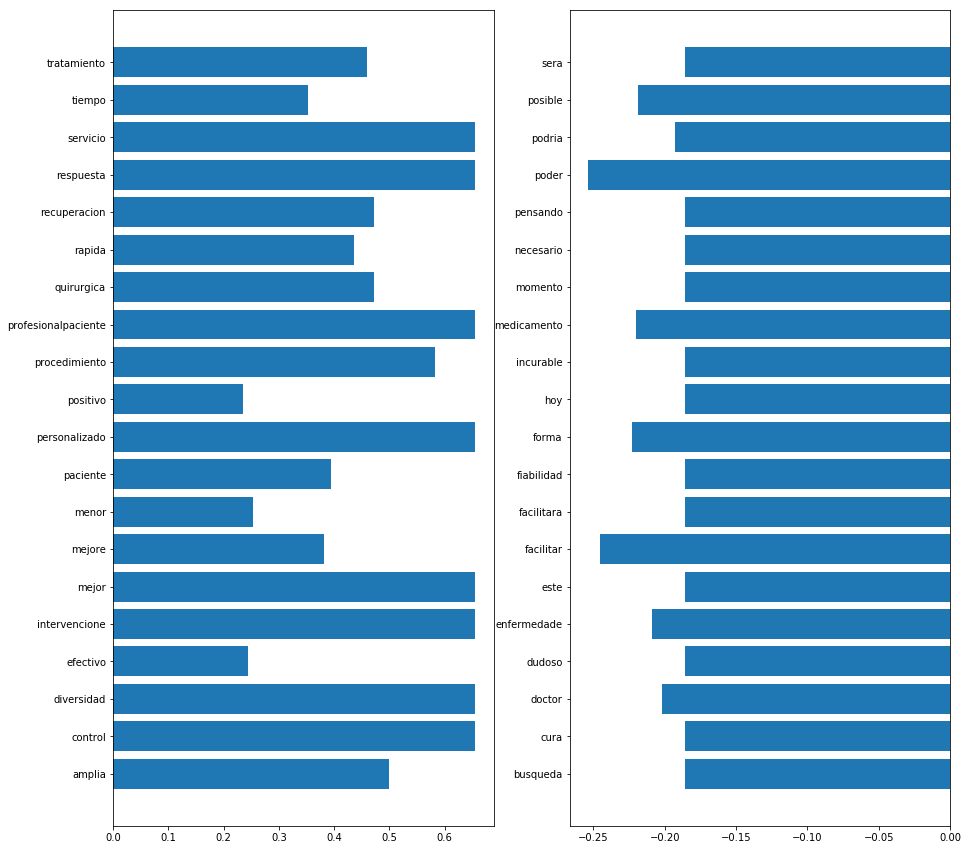

In [25]:
resultados_pregunta1 = datos_originales["¿Qué beneficios cree usted que puede tener esta inteligencia artificial en el campo de la medicina?"]
conteos,transformer,vectorizer,tfidf = calc_tf_idf(resultados_pregunta1)

correlacion_pos,correlacion_neg = correlacion_edad_palabras(conteos,datos_originales.Edad,vectorizer)



* Mientras mas aumenta la edad ,mas aumenta la manifestación de cosas como :tiempos,servicios,respuesta,personalizados(diagnosticos) y control. como un beneficio de la IA.
* Mientras mas aumenta la edad, mas disminuye la manifestación de beneficios como "facilitar"  de la IA.

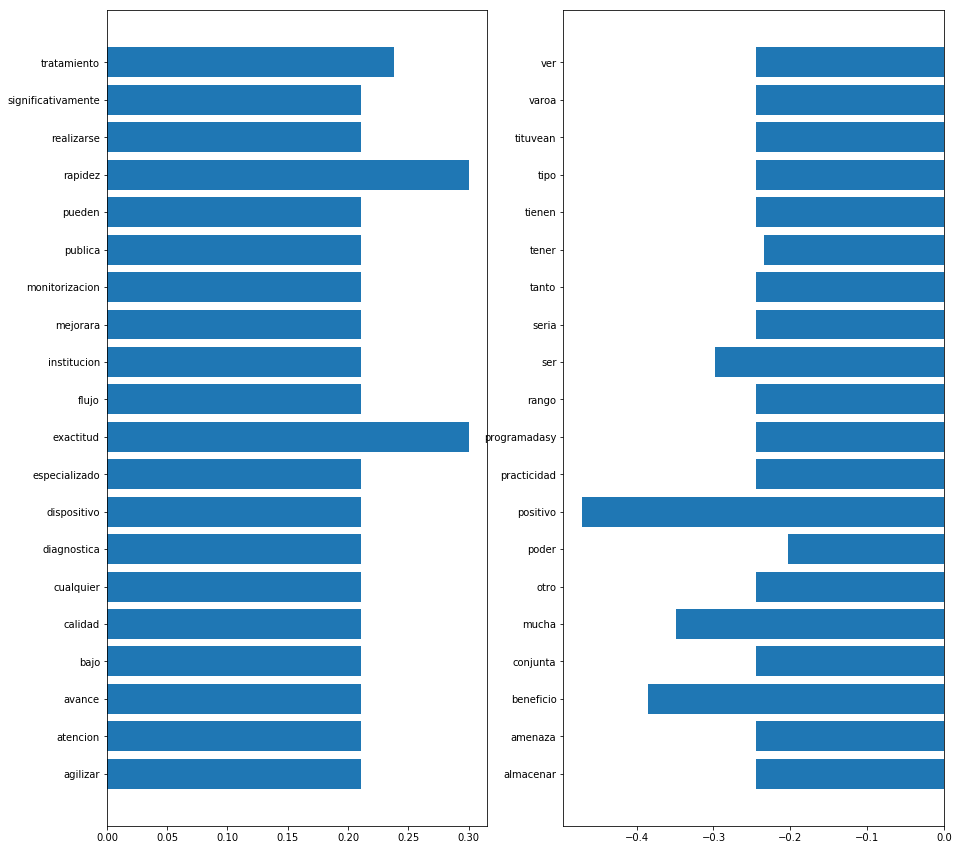

In [26]:
correlacion_pos,correlacion_neg = correlacion_edad_palabras(conteos,datos_originales["Nivel Educativo"],vectorizer)

## Pregunta 2:  Le han realizado una tomografía de cráneo a usted o a un familiar o conocido cercano, ¿para qué le sirvió a su médico este estudio?

### Análisis de frecuencia de palabras

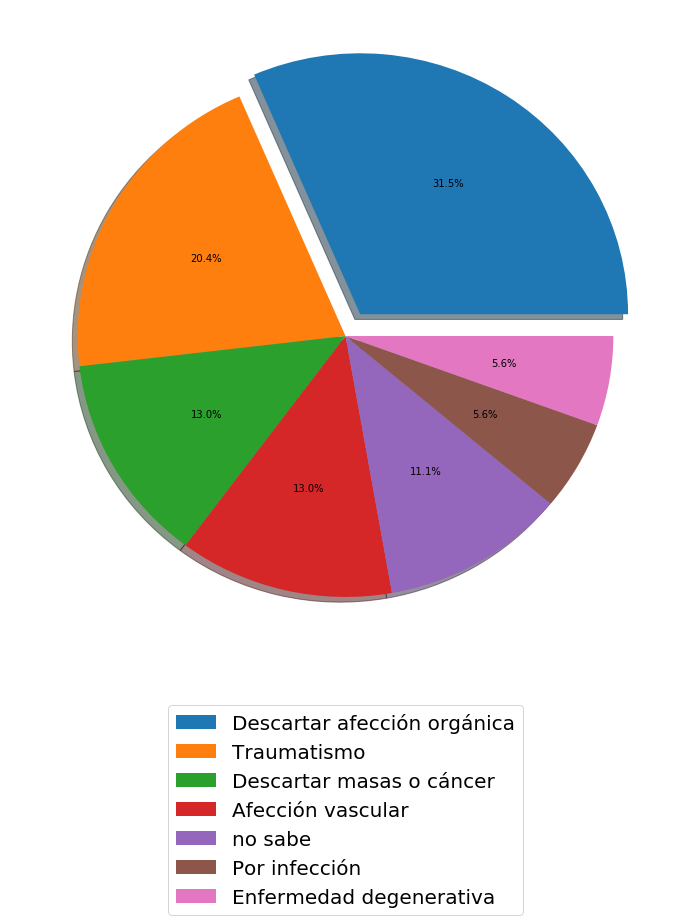

Descartar afección orgánica    17
Traumatismo                    11
Descartar masas o cáncer        7
Afección vascular               7
no sabe                         6
Por infección                   3
Enfermedad degenerativa         3
Name: Le han realizado una tomografía de cráneo a usted o a un familiar o conocido cercano, ¿para qué le sirvió a su médico este estudio?, dtype: int64

In [27]:
pregunta="Le han realizado una tomografía de cráneo a usted o a un familiar o conocido cercano, ¿para qué le sirvió a su médico este estudio?"
analisis_categorias(datos_segunda_pregunta,pregunta)

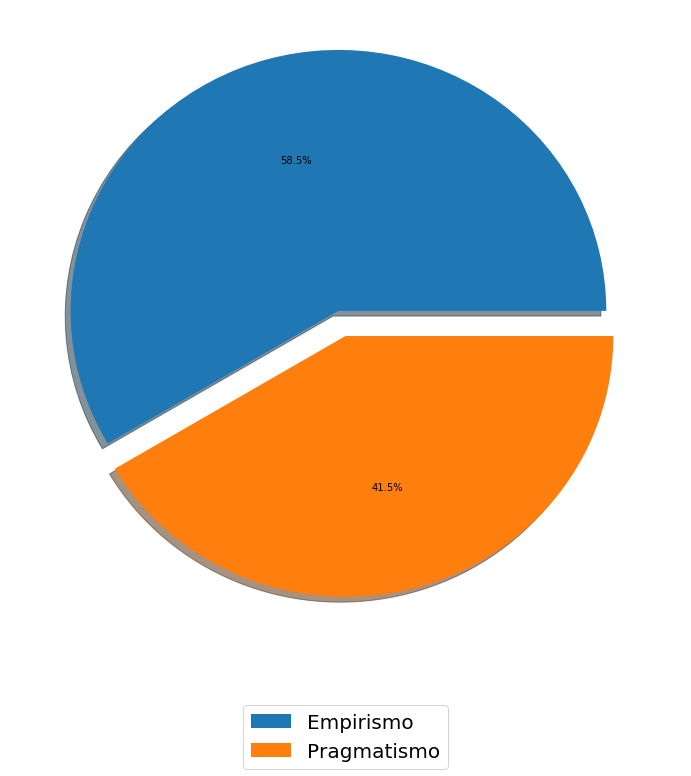

Empirismo      31
Pragmatismo    22
Name: TIPO CONOCIMIENTO, dtype: int64

In [42]:
pregunta="TIPO CONOCIMIENTO"
analisis_categorias(datos_segunda_pregunta,pregunta)

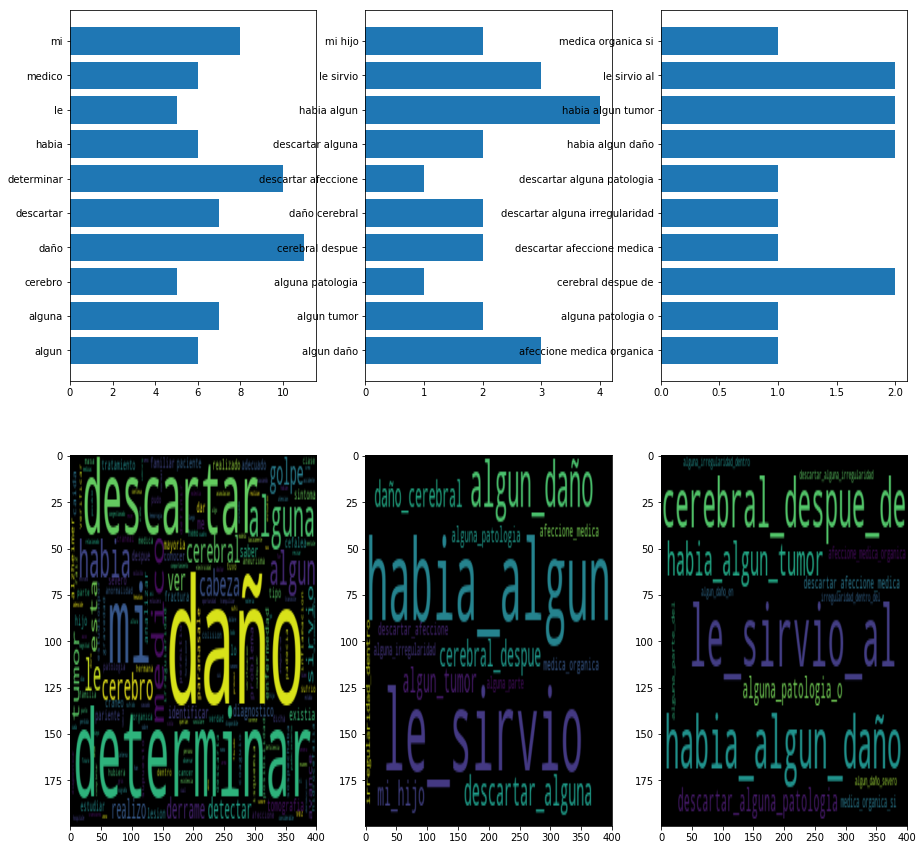

In [28]:
resultados_pregunta2 = datos_originales["Le han realizado una tomografía de cráneo a usted o a un familiar o conocido cercano, ¿para qué le sirvió a su médico este estudio?"]
pregunta2_corpus = resultados_pregunta2.str.cat(sep=" ")
resultado = analisis_frecuencia_palabras(pregunta2_corpus)

resultados_pregunta1 = datos_originales["Le han realizado una tomografía de cráneo a usted o a un familiar o conocido cercano, ¿para qué le sirvió a su médico este estudio?"]
conteos,transformer,vectorizer,tfidf = calc_tf_idf(resultados_pregunta1)

correlacion_pos,correlacion_neg = correlacion_edad_palabras(conteos,datos_originales.Edad,vectorizer)

## Pregunta 3: ¿Qué beneficio cree que pueda tener la inteligencia artificial en el estudio que su médico le solicitó a su familiar?

### Análisis de frecuencia de palabras

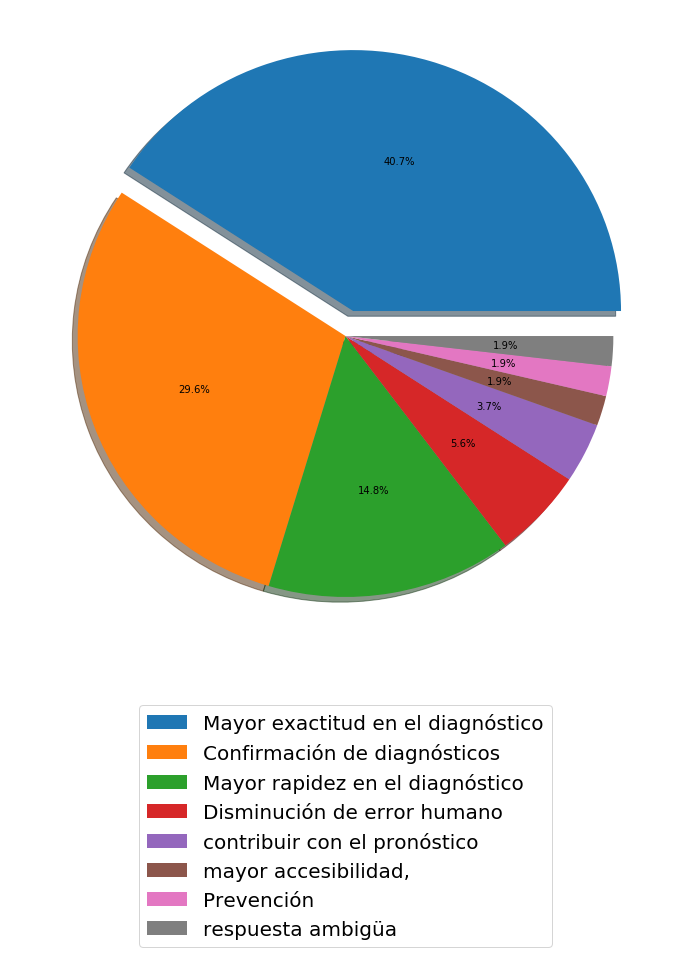

Mayor exactitud en el diagnóstico    22
Confirmación de diagnósticos         16
Mayor rapidez en el diagnóstico       8
Disminución de error humano           3
contribuir con el pronóstico          2
mayor accesibilidad,                  1
Prevención                            1
respuesta ambigüa                     1
Name: 3. ¿Qué beneficio cree que pueda tener la inteligencia artificial en el estudio que su médico le solicitó a su familiar?, dtype: int64

In [29]:
pregunta="3. ¿Qué beneficio cree que pueda tener la inteligencia artificial en el estudio que su médico le solicitó a su familiar?"
analisis_categorias(datos_tercera_pregunta,pregunta)

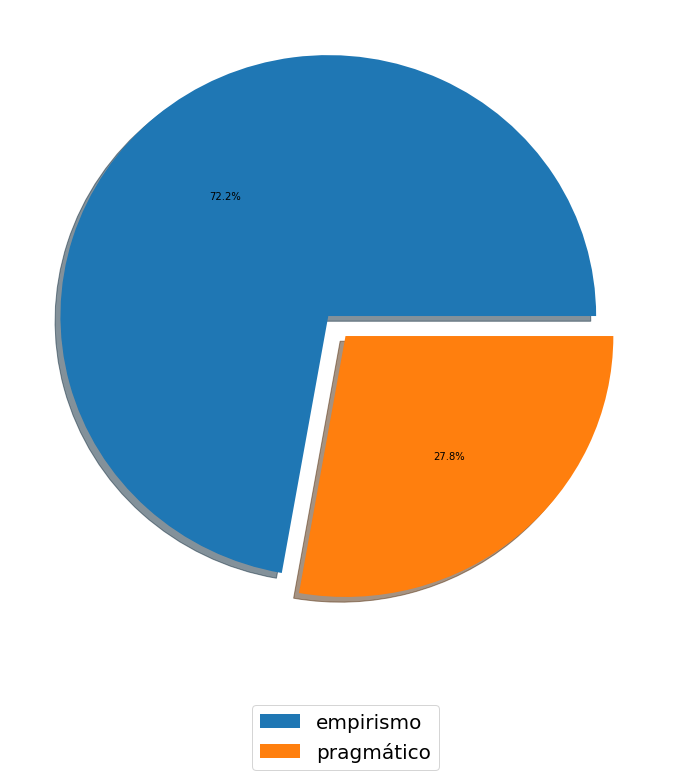

empirismo     39
pragmático    15
Name: TIPO CONOCIMIENTO, dtype: int64

In [43]:
pregunta="TIPO CONOCIMIENTO"
analisis_categorias(datos_tercera_pregunta,pregunta)

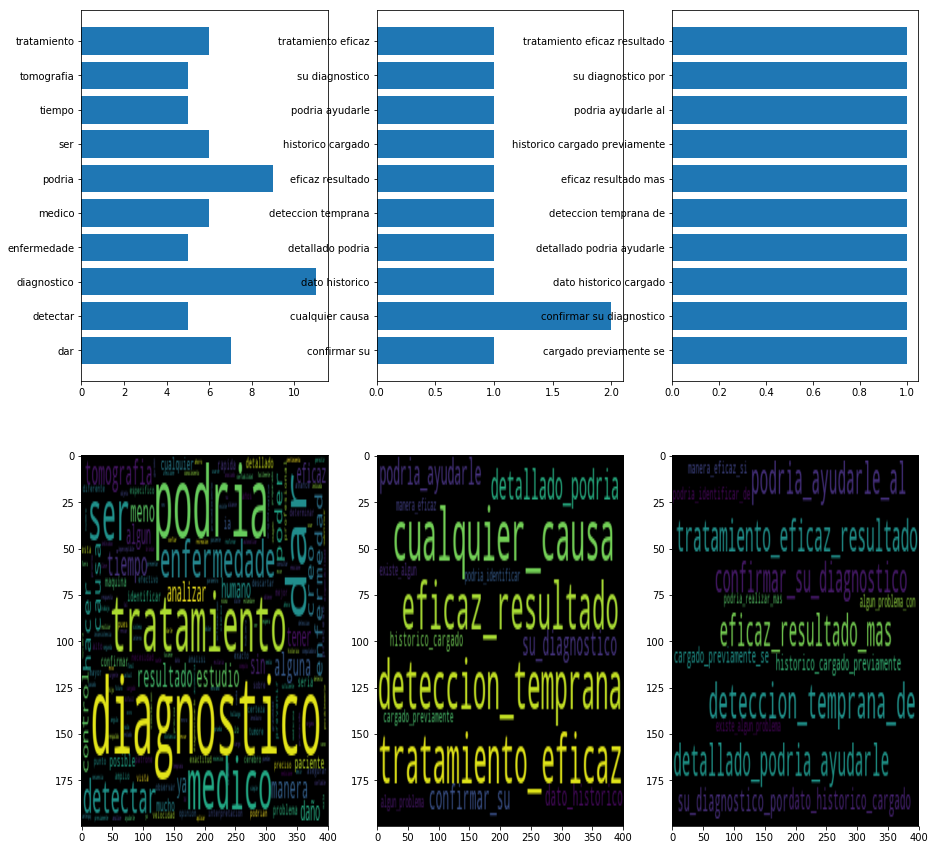

In [30]:
resultados_pregunta3 = datos_originales["¿Qué beneficio cree que pueda tener la inteligencia artificial en el estudio que su médico le solicitó a su familiar?"]
pregunta3_corpus = resultados_pregunta3.str.cat(sep=" ")
resultado = analisis_frecuencia_palabras(pregunta3_corpus)

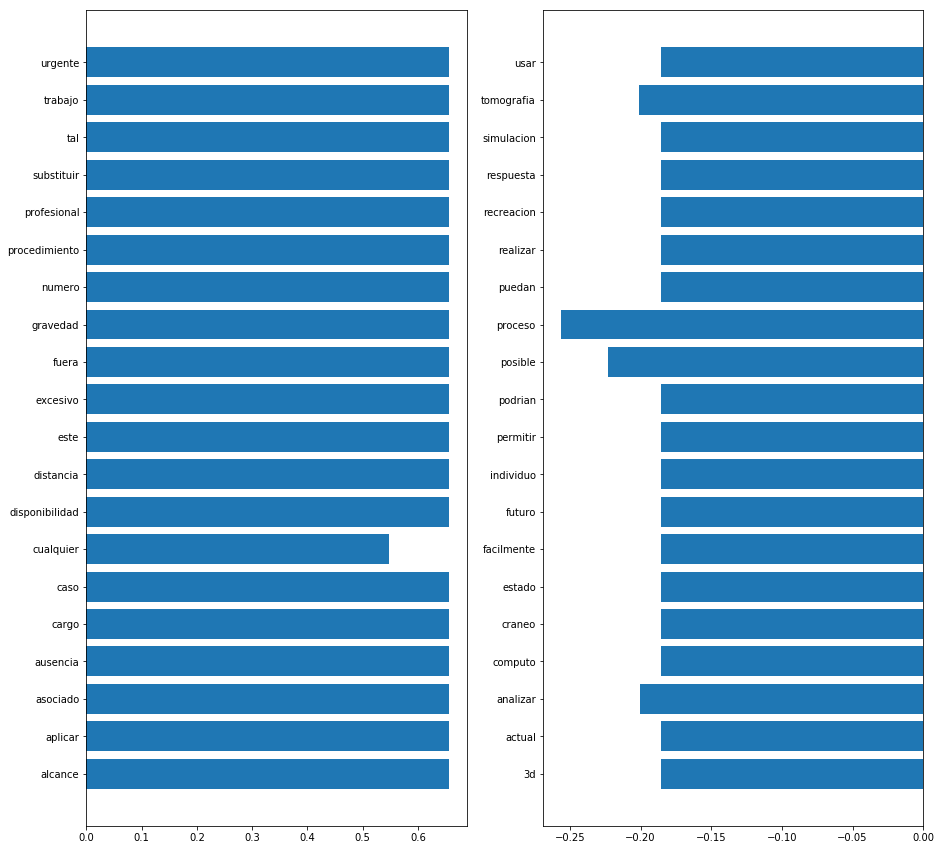

In [31]:
resultados_pregunta1 = datos_originales["¿Qué beneficio cree que pueda tener la inteligencia artificial en el estudio que su médico le solicitó a su familiar?"]
conteos,transformer,vectorizer,tfidf = calc_tf_idf(resultados_pregunta1)

correlacion_pos,correlacion_neg = correlacion_edad_palabras(conteos,datos_originales.Edad,vectorizer)

* Hay palabras  altamente correlacionadas con la edad, pero ninguna que sobresalga
* La palabra "proceso" esta correlacionada negativamente con la edad(a mayor edad) menos uso de proceso.

De momento parece que no se  puede concluir por edad.

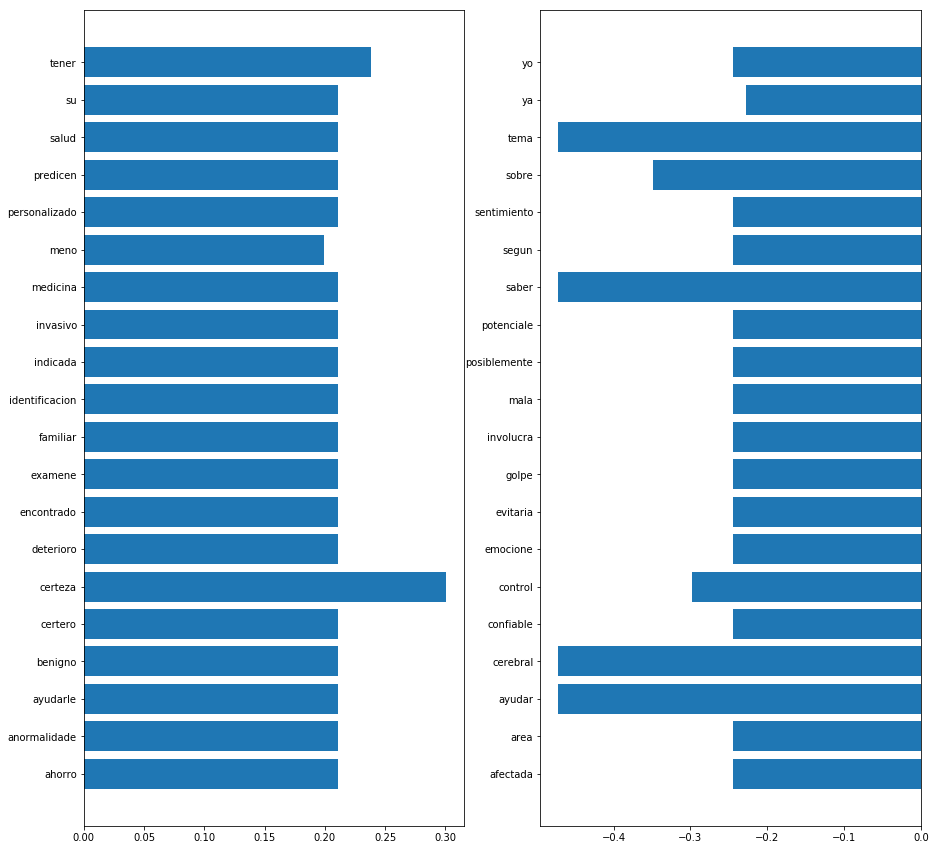

In [32]:
correlacion_pos,correlacion_neg = correlacion_edad_palabras(conteos,datos_originales["Nivel Educativo"],vectorizer)

## Pregunta 4: En su opinión, ¿qué beneficios o riesgo puede tener la inteligencia artificial?

### Análisis de frecuencia de palabras

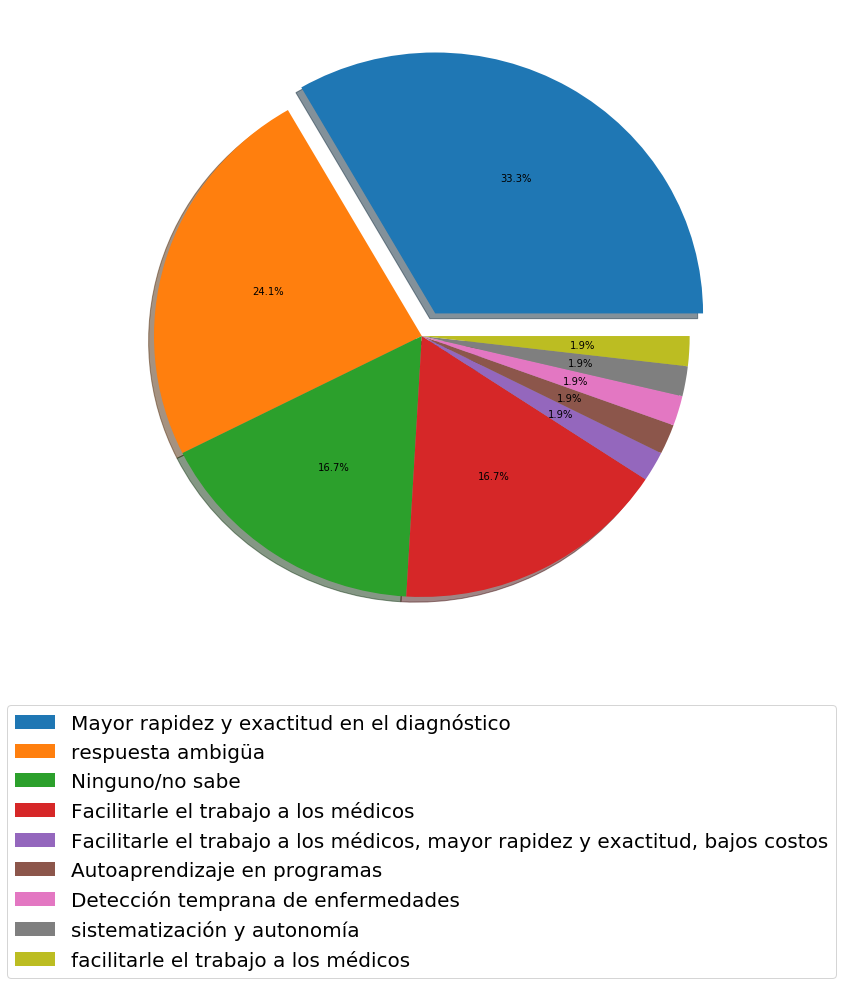

Mayor rapidez y exactitud en el diagnóstico                                      18
respuesta ambigüa                                                                13
Ninguno/no sabe                                                                   9
Facilitarle el trabajo a los médicos                                              9
Facilitarle el trabajo a los médicos, mayor rapidez y exactitud, bajos costos     1
Autoaprendizaje en programas                                                      1
Detección temprana de enfermedades                                                1
sistematización y autonomía                                                       1
facilitarle el trabajo a los médicos                                              1
Name: 4a. En su opinión, ¿qué beneficios puede tener la inteligencia artificial?, dtype: int64

In [33]:
pregunta="4a. En su opinión, ¿qué beneficios puede tener la inteligencia artificial?"
analisis_categorias(datos_cuarta_pregunta,pregunta)

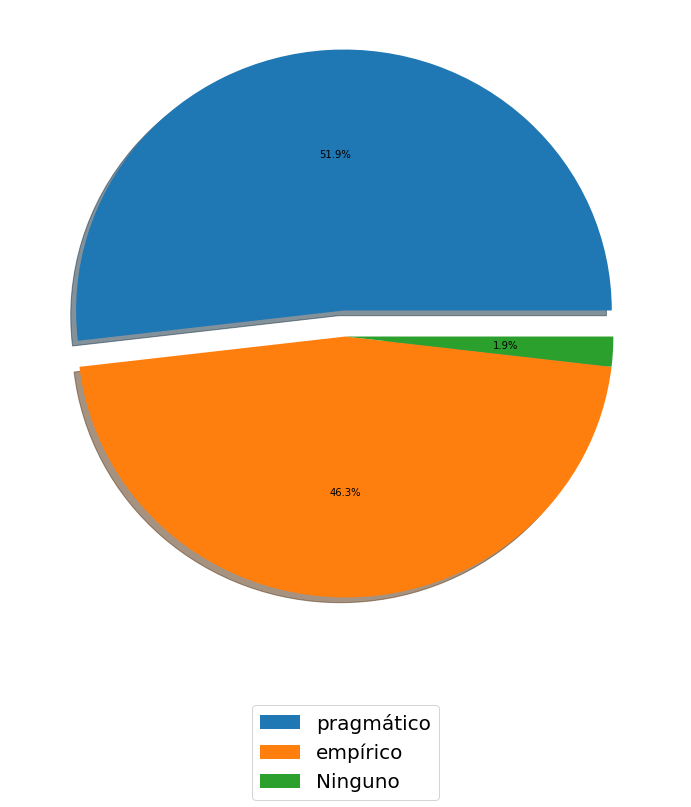

pragmático    28
empírico      25
Ninguno        1
Name: TIPO CONOCIMIENTO, dtype: int64

In [44]:
pregunta="TIPO CONOCIMIENTO"
analisis_categorias(datos_cuarta_pregunta,pregunta)

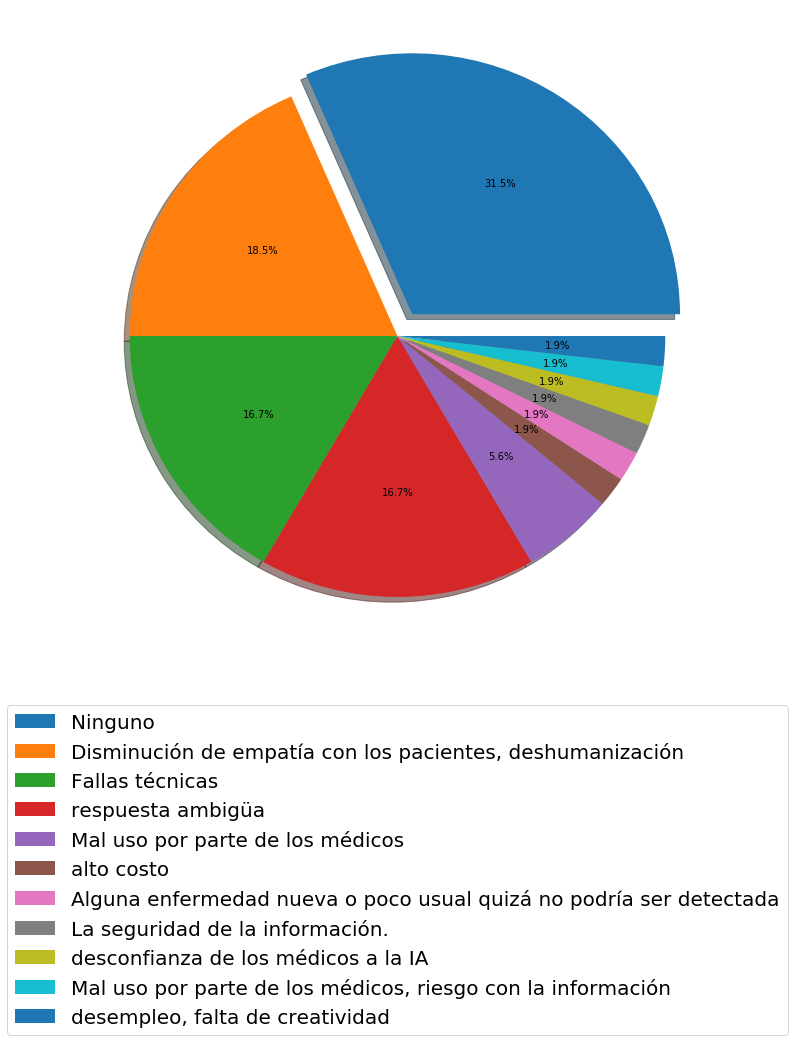

Ninguno                                                               17
Disminución de empatía con los pacientes, deshumanización             10
Fallas técnicas                                                        9
respuesta ambigüa                                                      9
Mal uso por parte de los médicos                                       3
alto costo                                                             1
Alguna enfermedad nueva o poco usual quizá no podría ser detectada     1
La seguridad de la información.                                        1
desconfianza de los médicos a la IA                                    1
Mal uso por parte de los médicos, riesgo con la información            1
desempleo, falta de creatividad                                        1
Name: 4b. En su opinión, ¿qué riesgo puede tener la inteligencia artificial?, dtype: int64

In [34]:
pregunta="4b. En su opinión, ¿qué riesgo puede tener la inteligencia artificial?"
analisis_categorias(datos_cuarta_pregunta,pregunta)

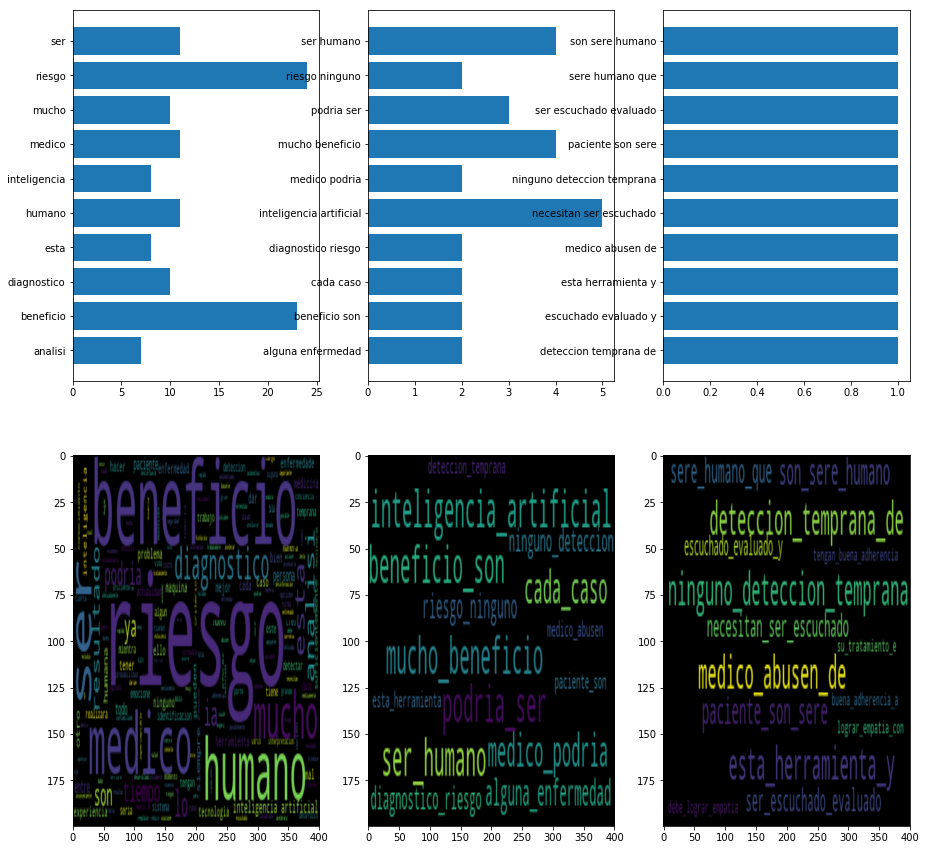

In [35]:
resultados_pregunta3 = datos_originales["En su opinión, ¿qué beneficios o riesgo puede tener la inteligencia artificial?"]
pregunta3_corpus = resultados_pregunta3.str.cat(sep=" ")
resultado = analisis_frecuencia_palabras(pregunta3_corpus)

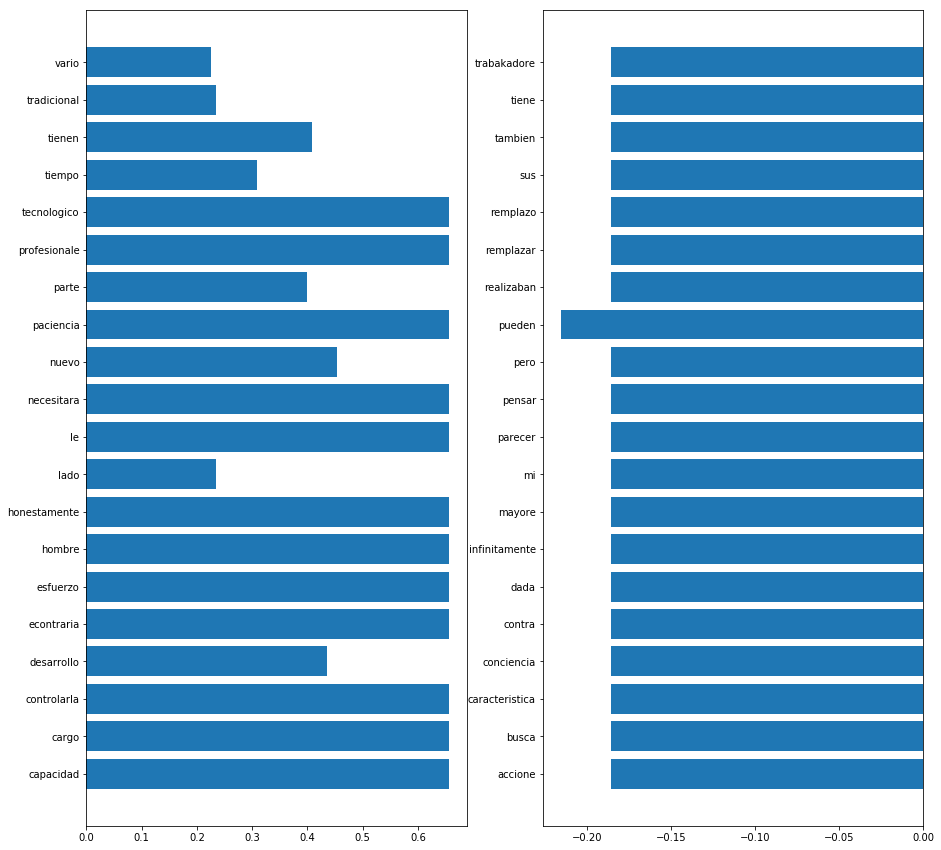

In [36]:
resultados_pregunta1 = datos_originales["En su opinión, ¿qué beneficios o riesgo puede tener la inteligencia artificial?"]
conteos,transformer,vectorizer,tfidf = calc_tf_idf(resultados_pregunta1)

correlacion_pos,correlacion_neg = correlacion_edad_palabras(conteos,datos_originales.Edad,vectorizer)

Hay palabras altamente correlacionadas con la edad,pero parecen no aportar información valiosa

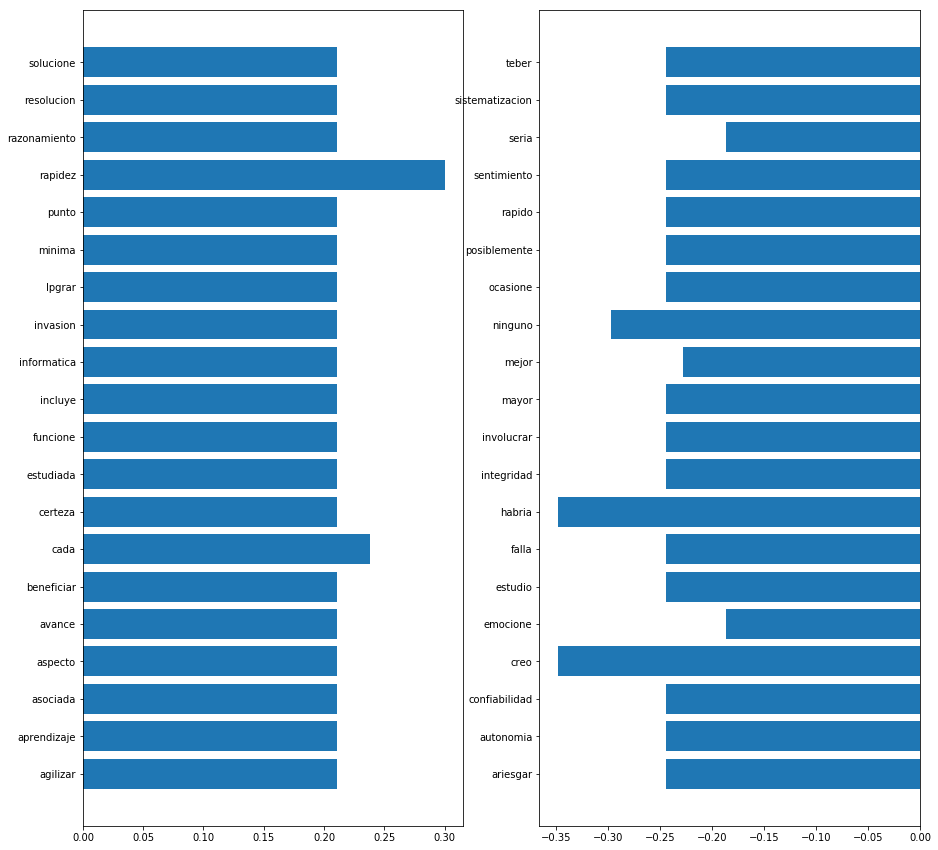

In [37]:
correlacion_pos,correlacion_neg = correlacion_edad_palabras(conteos,datos_originales["Nivel Educativo"],vectorizer)

## Pregunta 5: ¿Qué otros estudios médicos conoce, en los cuales considera que se pueda aplicar la inteligencia artificial?


### Análisis de frecuencia de palabras

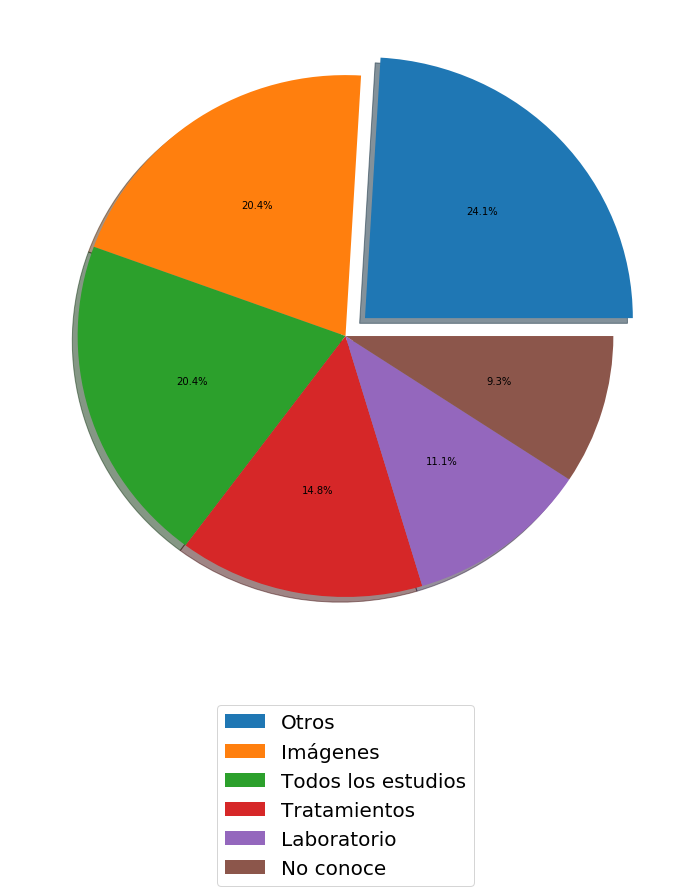

Otros                 13
Imágenes              11
Todos los estudios    11
Tratamientos           8
Laboratorio            6
No conoce              5
Name: 5. ¿Qué otros estudios médicos conoce, en los cuales considera que se pueda aplicar la inteligencia artificial?, dtype: int64

In [38]:
pregunta="5. ¿Qué otros estudios médicos conoce, en los cuales considera que se pueda aplicar la inteligencia artificial?"
analisis_categorias(datos_quinta_pregunta,pregunta)

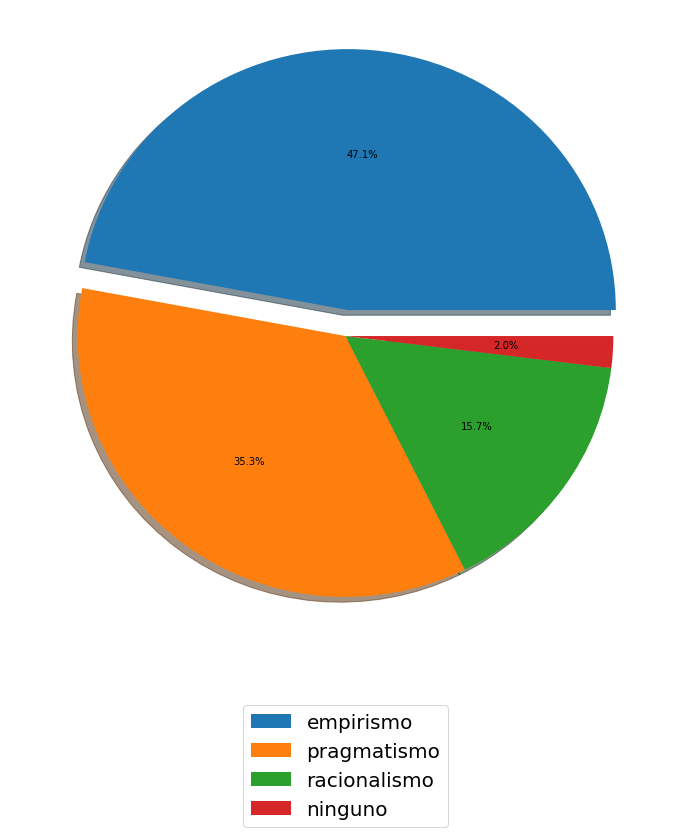

empirismo       24
pragmatismo     18
racionalismo     8
ninguno          1
Name: TIPO CONOCIMIENTO, dtype: int64

In [45]:
pregunta="TIPO CONOCIMIENTO"
analisis_categorias(datos_quinta_pregunta,pregunta)

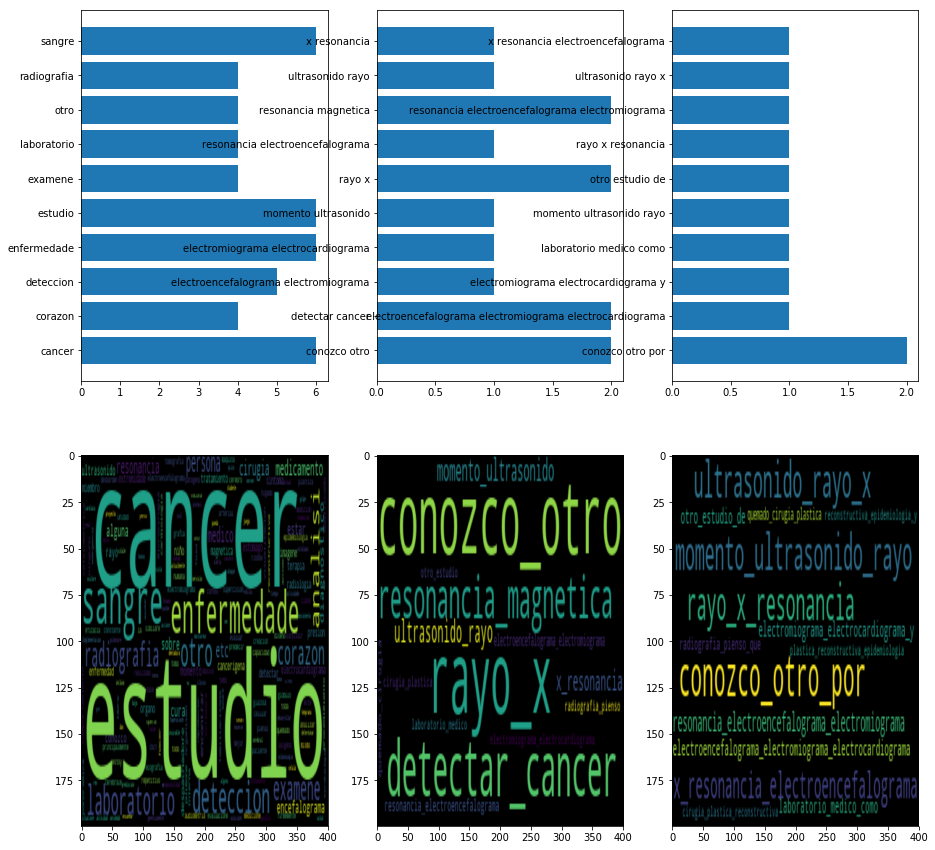

In [39]:
resultados_pregunta4 = datos_originales["¿Qué otros estudios médicos conoce, en los cuales considera que se pueda aplicar la inteligencia artificial?"]
pregunta4_corpus = resultados_pregunta4.str.cat(sep=" ")
resultado = analisis_frecuencia_palabras(pregunta4_corpus)

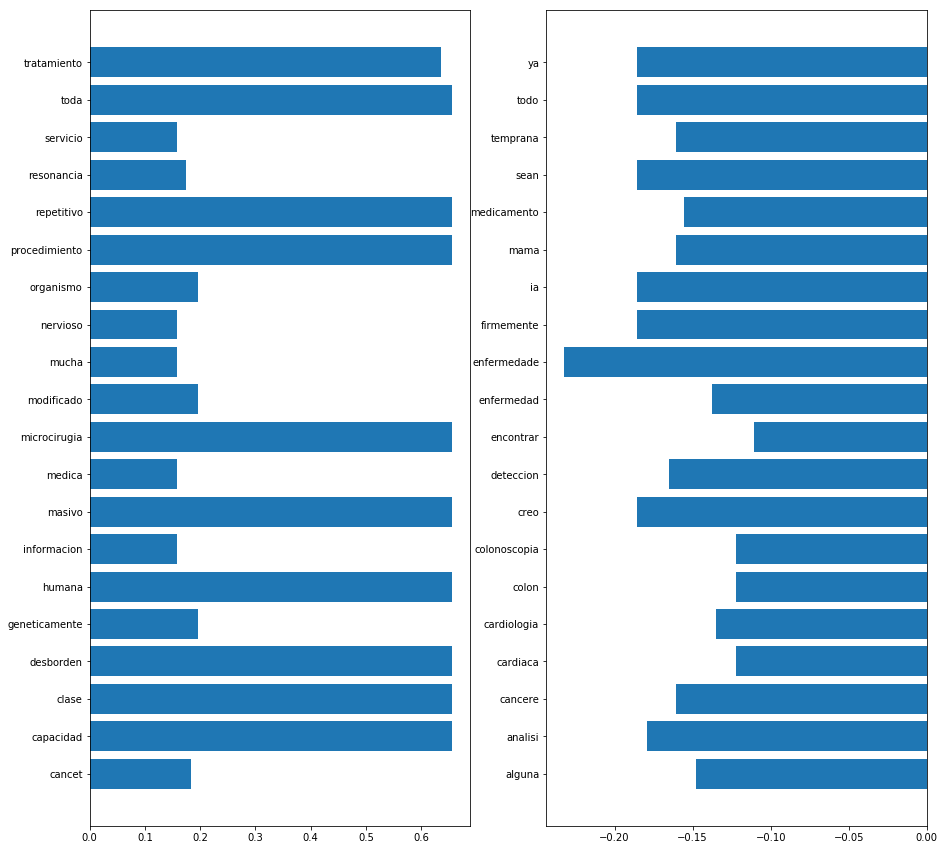

In [40]:
resultados_pregunta1 = datos_originales["¿Qué otros estudios médicos conoce, en los cuales considera que se pueda aplicar la inteligencia artificial?"]
conteos,transformer,vectorizer,tfidf = calc_tf_idf(resultados_pregunta1)

correlacion_pos,correlacion_neg = correlacion_edad_palabras(conteos,datos_originales.Edad,vectorizer)

* Hay palabras correlacionadas con la edad, entre ellas destaca "microcirugía" ,conforme avanza la edad se necesitan mas cirugías?
* La palabra "enfermedades"  para disminuir su uso conforme aumenta la edad.

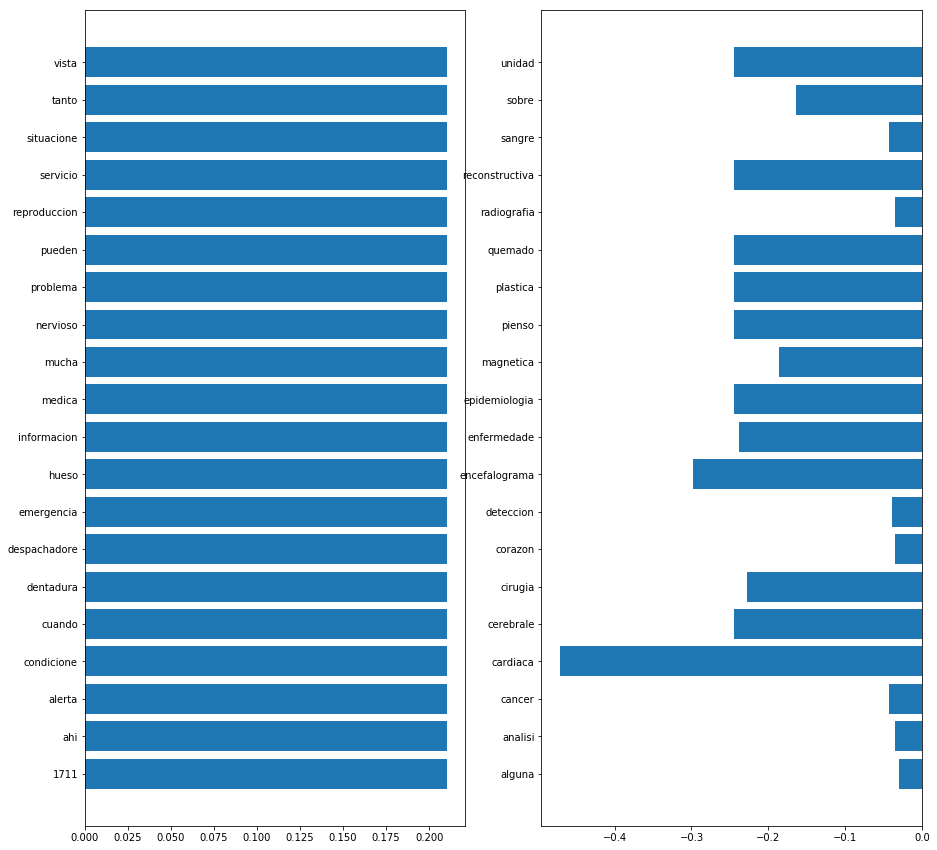

In [41]:
correlacion_pos,correlacion_neg = correlacion_edad_palabras(conteos,datos_originales["Nivel Educativo"],vectorizer)

## Algunos resultados obtenidos del análisis de información.

1. El conocimiento que tiene la población estudiada sobre la aplicación de la IA en medicina es empírico o pragmatico? ** Aunque la mayoría no sabe con exactitud y de manera técnica que es la IA, la mayoría expresa beneficios que esta puede tener,lo cual enmarca el conocimento como prágmatismo. **